<a href="https://colab.research.google.com/github/DeimosRecan/RecomSysYT/blob/main/RecSys_Day3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Интенсив "Пишем рекомендательную систему как в YouTube (почти)"
## День 3

### Загрузим и обработаем данные

In [ ]:
import pandas as pd

data = pd.read_csv("./video_dataset.csv")

data_small = data.loc[:, ['id', 'title', 'description', 'thumbnail_medium', 'tags', 'views', 'likes']]

In [ ]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import re

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
STOPWORDS = set(stopwords.words('english'))
MIN_WORDS = 4
MAX_WORDS = 200

PATTERN_S = re.compile("\'s")  # matches `'s` from text
PATTERN_RN = re.compile("\\r\\n") #matches `\r` and `\n`
PATTERN_PUNC = re.compile(r"[^\w\s]") # matches all non 0-9 A-z whitespace

def clean_text(text):
    text = text.lower()
    # replace the matched string with ' '
    text = re.sub(PATTERN_S, ' ', text)
    text = re.sub(PATTERN_RN, ' ', text)
    text = re.sub(PATTERN_PUNC, ' ', text)
    return text

def tokenizer(sentence, min_words=MIN_WORDS, max_words=MAX_WORDS, stopwords=STOPWORDS, lemmatize=True):
    if lemmatize:
        stemmer = WordNetLemmatizer()
        tokens = [stemmer.lemmatize(w) for w in word_tokenize(sentence)]
    else:
        tokens = [w for w in word_tokenize(sentence)]
    token = [w for w in tokens if (len(w) > min_words and len(w) < max_words
                                                        and w not in stopwords)]
    return tokens

def clean_sentences(df):
    print('Cleaning sentences...')
    df['clean_sentence'] = df['sentence'].apply(clean_text)
    df['tok_lem_sentence'] = df['clean_sentence'].apply(
        lambda x: tokenizer(x, min_words=MIN_WORDS, max_words=MAX_WORDS, stopwords=STOPWORDS))
    return df

from ast import literal_eval

data_small['tags_text'] = data_small['tags'].apply(lambda x: ' '.join(literal_eval(x)) if isinstance(x, str) else '')

def create_combined_data(x):
    result = x['description'] if isinstance(x['description'], str) else ''
    return result + ' ' + x['tags_text']

data_small['sentence'] = data_small.apply(create_combined_data, axis=1)
data_clean = clean_sentences(data_small)

Cleaning sentences...


### Сделаем предсказательную систему

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def extract_best_indices(m, topk, mask=None):
    if len(m.shape) > 1:
        cos_sim = np.mean(m, axis=0)
    else:
        cos_sim = m

    index = np.argsort(cos_sim)[::-1]
    if mask is not None:
        assert mask.shape == m.shape
        mask = mask[index]
    else:
        mask = np.ones(len(cos_sim))
    mask = np.logical_or(cos_sim[index] != 0, mask)
    best_index = index[mask][:topk]
    return best_index

In [ ]:
import spacy

!python -m spacy download en_core_web_lg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 1.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
def predict_spacy(model, query_sentence, embed_mat, topk=3):
    query_embed = model(query_sentence)
    mat = np.array([query_embed.similarity(line) for line in embed_mat])

    mat_mask = np.array(
        [True if line.vector_norm else False for line in embed_mat])
    best_index = extract_best_indices(mat, topk=topk, mask=mat_mask)
    return best_index

In [ ]:
nlp = spacy.load("en_core_web_lg")
data_clean['spacy_sentence'] = data_clean['sentence'].apply(lambda x: nlp(x))
embed_mat = data_clean['spacy_sentence'].values

In [ ]:
test_sentence = 'Data eng'
best_index = predict_spacy(nlp, test_sentence, embed_mat)

display(data_small[['title', 'sentence']].iloc[best_index]);

<ipython-input-7-b4f363494ea5>:3: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  mat = np.array([query_embed.similarity(line) for line in embed_mat])


,title,sentence
126,Economic Data Analysis Project with Python Pan...,In this video kaggle grandmaster Rob Mulla tak...
122,Data Analytics with Python | Python for Data A...,🔵 Intellipaat Data Analytics training course: ...
6,The 7 steps of machine learning,How can we tell if a drink is beer or wine? Ma...


### Сделаем интерфейс чуть удобнее и приятнее

In [ ]:
def predict_top3(movie_id, data, model):
    test_sentence = data.iloc[movie_id]['clean_sentence']
    embed_mat = data['spacy_sentence'].values
    best_index = predict_spacy(nlp, test_sentence, embed_mat)
    return data.iloc[best_index]

In [ ]:
prediction = predict_top3(23, data_clean, nlp)

display(prediction)

<ipython-input-7-b4f363494ea5>:3: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  mat = np.array([query_embed.similarity(line) for line in embed_mat])


,id,title,description,thumbnail_medium,tags,views,likes,tags_text,sentence,clean_sentence,tok_lem_sentence,spacy_sentence
193,I6N5xf8NOz0,Backend development using Django 2,Course link:\nhttps://courses.learncodeonline....,https://i.ytimg.com/vi/I6N5xf8NOz0/mqdefault.jpg,"['Programming', 'LearnCodeOnline', 'Django', '...",42174.0,830.0,Programming LearnCodeOnline Django Django 2 Ba...,Course link:\nhttps://courses.learncodeonline....,course link \nhttps courses learncodeonline ...,"[course, link, http, course, learncodeonline, ...","(Course, link, :, \n, https://courses.learncod..."
16,f_uwKZIAeM0,What is Machine Learning?,Machine learning is all around us; on our phon...,https://i.ytimg.com/vi/f_uwKZIAeM0/mqdefault.jpg,"['machine learning', 'machienes', 'computer le...",451628.0,3180.0,machine learning machienes computer learning c...,Machine learning is all around us; on our phon...,machine learning is all around us on our phon...,"[machine, learning, is, all, around, u, on, ou...","(Machine, learning, is, all, around, us, ;, on..."
131,b0L47BeklTE,Linear Regression Python Sklearn [FROM SCRATCH],linear regression python sklearn. In this vide...,https://i.ytimg.com/vi/b0L47BeklTE/mqdefault.jpg,"['Linear Regression Sklearn Example', 'linear ...",60010.0,895.0,Linear Regression Sklearn Example linear regre...,linear regression python sklearn. In this vide...,linear regression python sklearn in this vide...,"[linear, regression, python, sklearn, in, this...","(linear, regression, python, sklearn, ., In, t..."


In [ ]:
from PIL import Image
import requests
from io import BytesIO

In [ ]:
def show_info(data, video_id):
    video = data.iloc[video_id]
    print("Описание фильма с номером", video_id)
    print(video['description'])
    print(video['thumbnail_medium'])
    response = requests.get(video['thumbnail_medium'])
    thumbnail = Image.open(BytesIO(response.content))
    display(thumbnail)

Описание фильма с номером 23
We haven't got time to label things, so can we let the computers work it out for themselves? Professor Uwe Aickelin explains supervised and un-supervised methods of machine learning.

Silicon Brain: 1,000,000 ARM Cores: https://youtu.be/2e06C-yUwlc 
Brian Kerninghan on Bell Labs: https://youtu.be/QFK6RG47bww
Could We Ban Encryption?: https://youtu.be/ShUyfk4QB-8 
Computer That Changed Everything - Altair 8800: https://youtu.be/6LYRgrqJgDc

http://www.facebook.com/computerphile
https://twitter.com/computer_phile

This video was filmed and edited by Sean Riley.

Computer Science at the University of Nottingham: http://bit.ly/nottscomputer

Computerphile is a sister project to Brady Haran's Numberphile. More at http://www.bradyharan.com
https://i.ytimg.com/vi/qDbpYUbf3e0/mqdefault.jpg


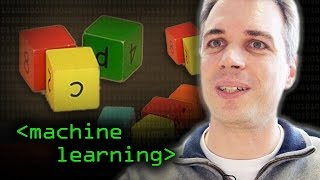

In [ ]:
show_info(data_clean, 23)

In [ ]:
def show_predictions(data, model):
    video_id = int(input())
    print("ВХОДНЫЕ ДАННЫЕ:")
    show_info(data, video_id)
    print("------------------\n\n")
    print("ПРЕДСКАЗАНИЯ")

    prediction = predict_top3(video_id, data, model)
    for i in range(3):
        show_info(data, list(prediction.index)[i])
        print('\n\n')

In [ ]:
prediction = predict_top3(23, data_clean, nlp)

<ipython-input-7-b4f363494ea5>:3: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  mat = np.array([query_embed.similarity(line) for line in embed_mat])


In [ ]:
prediction.index

Index([193, 16, 131], dtype='int64')

23
ВХОДНЫЕ ДАННЫЕ:
Описание фильма с номером 23
We haven't got time to label things, so can we let the computers work it out for themselves? Professor Uwe Aickelin explains supervised and un-supervised methods of machine learning.

Silicon Brain: 1,000,000 ARM Cores: https://youtu.be/2e06C-yUwlc 
Brian Kerninghan on Bell Labs: https://youtu.be/QFK6RG47bww
Could We Ban Encryption?: https://youtu.be/ShUyfk4QB-8 
Computer That Changed Everything - Altair 8800: https://youtu.be/6LYRgrqJgDc

http://www.facebook.com/computerphile
https://twitter.com/computer_phile

This video was filmed and edited by Sean Riley.

Computer Science at the University of Nottingham: http://bit.ly/nottscomputer

Computerphile is a sister project to Brady Haran's Numberphile. More at http://www.bradyharan.com
https://i.ytimg.com/vi/qDbpYUbf3e0/mqdefault.jpg


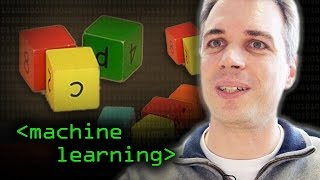

------------------


ПРЕДСКАЗАНИЯ
Описание фильма с номером 193
Course link:
https://courses.learncodeonline.in/learn/BackEnd-web-development-with-Django

Hi and welcome to BackEnd Development for Beginners using Django - Build 8 Projects. 
Before we talk anything about this course, let’s get clear about what you should already know before taking this course.

NOTE: This course is on Django 2

Front end basics
If you have taken my Complete front-end developer Bootcamp or any other such course where things like HTML and basics of CSS got cleared, then you are good to go for next requirement. This is a backend focused course and we will not be talking much about stuff like “How to change background color”.

2. Python Basics
Django is based on python and it will be a good idea to clear your python basics before taking this course. Things like Loops, If Else, Functions and Classes are used in this course, with expectation that you are aware of it. You don’t need to be a guru in python but 

<ipython-input-7-b4f363494ea5>:3: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  mat = np.array([query_embed.similarity(line) for line in embed_mat])


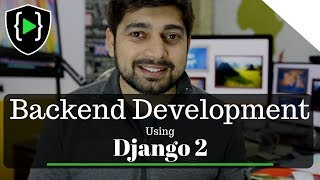




Описание фильма с номером 16
Machine learning is all around us; on our phones, powering social networks, helping the police and doctors, scientists and mayors. But how does it work? In this animation we take a look at how statistics and computer science can be used to make machines that learn. 

Visit www.oxfordsparks.ox.ac.uk to find out more. 
Don’t forget to connect with us on Facebook @OxSparks and on Twitter @OxfordSparks Instagram: @OxfordSparks
https://i.ytimg.com/vi/f_uwKZIAeM0/mqdefault.jpg


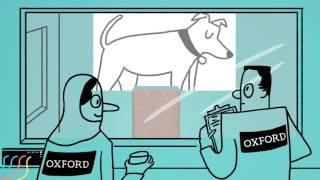




Описание фильма с номером 131
linear regression python sklearn. In this video we will learn how to use SkLearn for linear regression in Python. You can follow along with this linear regression sklearn python example. The linear regression in python will be done using SKlearn. The first thing we need to do is import. We will import a pydataset to use in this example. And let’s get Pandas and numpy. Next we import the thing we will need from sklearn. LinearRegression from the linear_model package, train test split, and lastly let’s get matplotlib in there so we can visualize this model. First of all, let’s get our data. We will be using the Pima women data. If you ever want to see details about a dataset you can enter in the keyword. Let’s check this data to see if it is approximately linear. In this example we will see if tricep skin fold measurements can predict body mass index (BMI). We can use the pandas plotting capabilities, with kind as scatter. There is the plot. This looks de

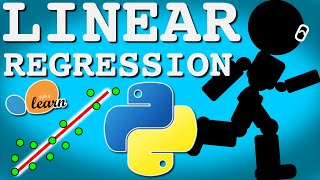

In [ ]:
show_predictions(data_clean, nlp)

### Сделаем интерфейс отдельно от ноутбука

In [ ]:
!pip install jupyter-dash

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 27.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 55.6 MB/s eta 0:00:00


In [ ]:
from jupyter_dash import JupyterDash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, State, Output

app = JupyterDash(__name__)

app.layout = html.Div([
    html.Div(dcc.Input(id='input-on-submit', type='text')),
    html.Button('Submit', id='submit-val', n_clicks=0),
    html.Div(id='container-button-basic',
             children='Enter a value and press submit'),
])

@app.callback(
    Output('container-button-basic', 'children'),
    Input('submit-val', 'n_clicks'),
    State('input-on-submit', 'value')
)
def update_output(n_clicks, value):
    prediction = predict_top3(int(value), data_clean, nlp)

    output = []
    for i in range(3):
      output.append('Описание для видео с индексом: ')
      output.append(str(prediction.index[i]))
      output.append(html.Br())
      output.append(html.Div([
           html.Img(src=prediction.iloc[i]['thumbnail_medium'])]))
      output.append(html.Br())
      output.append(prediction.iloc[i]['description'])
      output.append(html.Br())
      output.append(html.Br())
      output.append(html.Br())

    return html.P(output)

app.run_server(host='0.0.0.0')

<ipython-input-20-c2c561b6361d>:2: UserWarning: 
The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from dash import dcc`
  import dash_core_components as dcc
<ipython-input-20-c2c561b6361d>:3: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html
/usr/local/lib/python3.10/dist-packages/dash/dash.py:550: UserWarning:

JupyterDash is deprecated, use Dash instead.
See https://dash.plotly.com/dash-in-jupyter for more details.



<IPython.core.display.Javascript object>

Dash app running on:


<IPython.core.display.Javascript object>